In [1]:
from math import floor

#essential imports
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

#scraping imports
import requests
from bs4 import BeautifulSoup

#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt

#String matching
import re

# Date
import datetime as dt
# Sleep
import time

# Strict JSON conversion
import json 
import gzip 

# Progress display
from IPython.display import clear_output

# Amazon API querying
from amazon.api import AmazonAPI
from amazon.api import AsinNotFound

#garbage collector
import gc

#p value calculation
from scipy import stats

datapath = 'DATA/review/'

In [2]:
def gz_to_dataframe(datapath, filename):
    def parse(path): 
        g = gzip.open(path, 'rb') 
        for l in g: 
            yield eval(l) 
    def getDF(path): 
        i = 0 
        df = {} 
        for d in parse(path): 
            df[i] = d 
            i += 1 
        return pd.DataFrame.from_dict(df, orient='index') 
    return getDF(datapath+filename)

# Popularity

In [3]:
jsonNameFilm = ['reviews_Amazon_Instant_Video_5.json.gz',
          'reviews_Movies_and_TV_5.json.gz']

jsonNameMusic = ['reviews_CDs_and_Vinyl_5.json.gz'#,
          #'reviews_Digital_Music_5.json.gz'
                ]

In [4]:
def str2Date(s):
    month,day,year = s.split(" ")
    return int(year), int(month), int(day.replace(",",""))

def computeAgg(filenames, classification = ['year','month']):
    for i,filename in enumerate(filenames):
        print("starting opening: ",filename)
        df = gz_to_dataframe(datapath, filename)
        print("finished opening")
        df['year'], df['month'], df['day'] =  zip(*df['reviewTime'].map(str2Date))
        df2 = df[['year','month','day']]
        del df
        gc.collect()
        df3 = df2.groupby(classification).size()
        del df2
        gc.collect()
        print("df is appended")
        if i==0:
            b = df3
        else:
            b = b.add(df3, fill_value=0)
    print("finished the aggregation")
    return b 

popularityReviewFilm = computeAgg(jsonNameFilm)
popularityReviewMusic = computeAgg(jsonNameMusic)

starting opening:  reviews_Amazon_Instant_Video_5.json.gz
finished opening
df is appended
starting opening:  reviews_Movies_and_TV_5.json.gz
finished opening
df is appended
finished the aggregation
starting opening:  reviews_CDs_and_Vinyl_5.json.gz
finished opening
df is appended
finished the aggregation


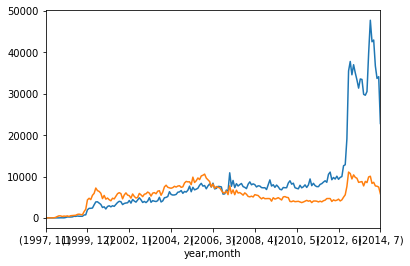

In [5]:
popularityReviewFilm.plot()
popularityReviewMusic.plot()

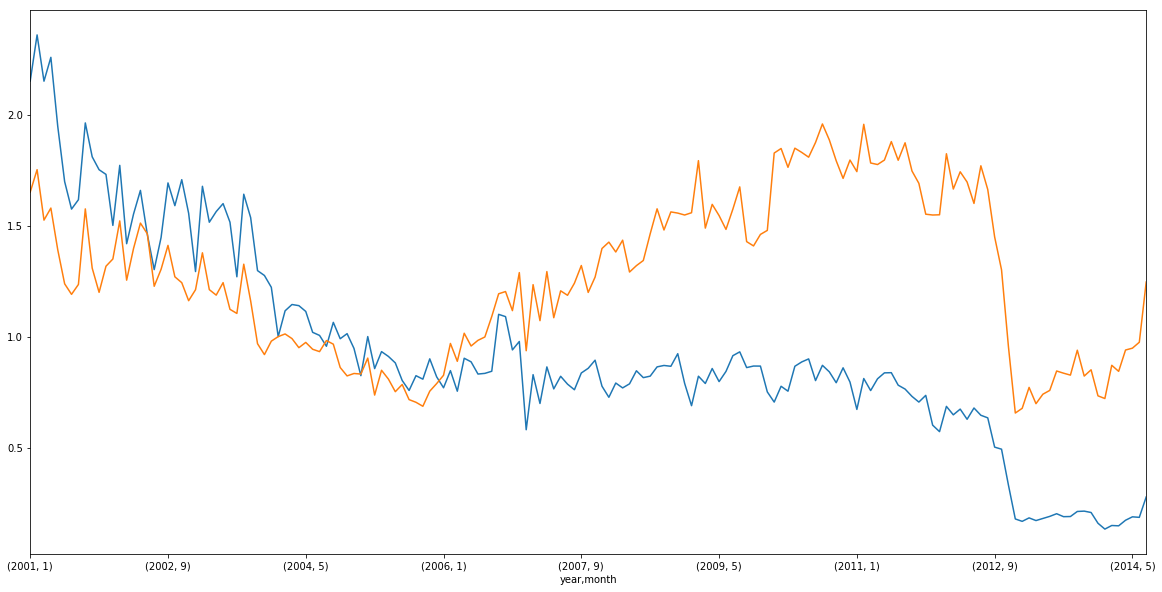

In [6]:
yearNorm = 2004
monthNorm = 1

yearThreshold = 2000

def computeInv(popularityReview,yearNorm,monthNorm):
    normreviews = popularityReview.loc[yearNorm,monthNorm]
    return popularityReview.copy().apply(lambda x: normreviews/x)
     

scalingReviewFilm = computeInv(popularityReviewFilm,yearNorm,monthNorm)
scalingReviewFilm = scalingReviewFilm.loc[scalingReviewFilm.index.get_level_values(0) > yearThreshold]

scalingReviewMusic = computeInv(popularityReviewMusic,yearNorm,monthNorm)
scalingReviewMusic = scalingReviewMusic.loc[scalingReviewMusic.index.get_level_values(0) > yearThreshold]

scalingReviewFilm.plot(figsize=(20,10))
scalingReviewMusic.plot(figsize=(20,10))


# Actor

In [7]:
df_actor_subject = pd.read_csv('reviews_subjects_500.csv')
df_actor_subject.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date,reviewYear,reviewTime,death year,mentionned
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03,2006,2006-04-07,1996,False
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03,2013,2013-03-24,1996,False
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03,2014,2014-04-05,1996,False
3,308662,0792840461,2012-12-21,2.0,"[3, 3]","great movie,but PLEASE avoid this copy.",an all-time great movie and one of my favorite...,jack weston,1996-05-03,2012,2012-12-21,1996,False
4,308663,0792840461,2013-05-12,5.0,"[0, 0]",It's McQueen,Fans of a rough and tough McQueen know that th...,jack weston,1996-05-03,2013,2013-05-12,1996,False


In [8]:
def dateAddMonth(date,month_to_add):
    year, month, day = date.split("-")
    year, month, day = int(year), int(month), int(day)
    month = month_to_add + month
    year+= floor(month/12)
    month=month%12
    if(month==0):
        month=12
        year-=1
    return str(year)+"-"+str(month).zfill(2)+"-"+str(day).zfill(2)

def sampledReviewForActorInTimestamp(df,actor,death_date,month_before,month_after):
    actors =  df['actor name'] == actor
    upperDate = dateAddMonth(death_date,month_after)
    lowerDate = dateAddMonth(death_date,-month_before)
    dateLowerBound = df['reviewTime']>lowerDate
    dateUpperBound =df['reviewTime']<upperDate 
    return df[actors & dateLowerBound & dateUpperBound]

In [9]:
def computeDiffReviewDateToDeathDate(row):
    yDead, mDead, dDead = row['death date'].split("-")
    yDead, mDead, dDead = int(yDead), int(mDead), int(dDead) 
    yReview, mReview, dReview = row['reviewTime'].split("-")
    yReview, mReview, dReview = int(yReview), int(mReview), int(dReview) 
    return (dt.datetime(yReview,mReview,dReview)-dt.datetime(yDead, mDead, dDead)).days 

In [10]:
def computeReviewsRatingPonderation(df,row):
    yReview, mReview, dReview = row['reviewTime'].split("-")
    yReview, mReview, dReview = int(yReview), int(mReview), int(dReview)
    return df.loc[yReview,mReview]

In [11]:
#return a list of tuples with actors and it's corresponding death date, in case of the control group, return the death date of its corresponding subject
def extractActors(df, yearThreshold, month_before):
    date = str(yearThreshold+1)+"-01-01"
    dateThreshold = dateAddMonth(date,month_before)
    return list(df[df['death date']>dateThreshold].groupby(['actor name','death date']).groups.keys())

In [12]:
#for all dead actors compute their normDays and add all together
month_before, month_after = 6, 6

def AggAllNormDays(df_person,df_review_popularity,dead_actors,month_before,month_after):
    first = True
    classification = ['year', 'month']
    for actor,death_date in dead_actors:
        df2 = sampledReviewForActorInTimestamp(df_person,actor,death_date,month_before,month_after).copy()
        if len(df2>0):
            df2['normDays'] = df2.apply(lambda row: computeDiffReviewDateToDeathDate(row),axis=1)
            df2['RatingValue'] = df2.apply(lambda row: computeReviewsRatingPonderation(df_review_popularity, row),axis=1)
            df2 = df2.groupby(['normDays'])['RatingValue'].sum()
            df2 = df2.rename(actor)
            if first:
                b = df2
                first = False
            else:
                b = pd.concat([b.reindex(list(range(-30*month_before,30*month_after))).fillna(0), df2], axis=1)
    return  b[b.index < 30*month_after].fillna(0)

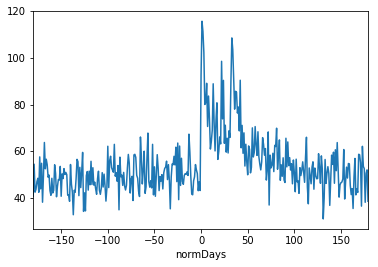

In [13]:
dead_actors = extractActors(df_actor_subject, yearThreshold, month_before)
subject_review_actor = AggAllNormDays(df_actor_subject, scalingReviewFilm, dead_actors, month_before, month_after)
subject_review_actor_curve = subject_review_actor.sum(axis=1)
subject_review_actor_curve.plot()

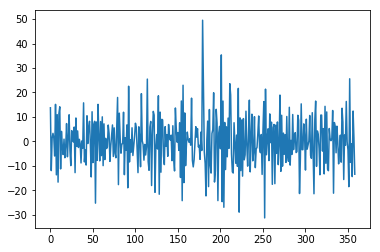

In [14]:
plt.plot(np.diff(subject_review_actor_curve))

In [15]:
df_actor_control = pd.read_csv('reviews_controls_500.csv')
df_actor_control.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,reviewYear,reviewTime,mentionned
0,827321,630327417X,2009-10-15,5.0,"[0, 1]",Great Movie,Nothing bad to say. Dvd came quickly and in gr...,michael hynson,2009,2009-10-15,False
1,827322,630327417X,2000-09-16,5.0,"[0, 0]",endless summer,its just to good for words!,michael hynson,2000,2000-09-16,False
2,827323,630327417X,2005-03-03,1.0,"[5, 58]",A very disappointed lover of documentaries,I feel obligated to warn you-as I wish I was w...,michael hynson,2005,2005-03-03,False
3,827324,630327417X,2005-09-23,5.0,"[3, 8]","Si eres surfer de Corazon, te gustara","Excelente pelicula, te sirve para saber el ini...",michael hynson,2005,2005-09-23,False
4,827325,630327417X,2000-06-23,5.0,"[7, 8]",The definitive surfer's movie -- get the feel...,"This movie provides a connection to surf, surf...",michael hynson,2000,2000-06-23,False


In [16]:
matching_subject_actor_control = pd.read_csv('matchings_500_feature=yearbefore.csv')
matching_subject_actor_control = matching_subject_actor_control[['ctrl_name','death date']].set_index('ctrl_name')

In [17]:
def computeDeathDateCtrl(matching,row):
    actor = row['actor name']
    if actor in matching.index:
        return matching.loc[actor]
    return np.nan

In [18]:
df_actor_control['death date'] = df_actor_control.apply(lambda row: computeDeathDateCtrl(matching_subject_actor_control, row),axis=1)
df_actor_control.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,reviewYear,reviewTime,mentionned,death date
0,827321,630327417X,2009-10-15,5.0,"[0, 1]",Great Movie,Nothing bad to say. Dvd came quickly and in gr...,michael hynson,2009,2009-10-15,False,2001-08-04
1,827322,630327417X,2000-09-16,5.0,"[0, 0]",endless summer,its just to good for words!,michael hynson,2000,2000-09-16,False,2001-08-04
2,827323,630327417X,2005-03-03,1.0,"[5, 58]",A very disappointed lover of documentaries,I feel obligated to warn you-as I wish I was w...,michael hynson,2005,2005-03-03,False,2001-08-04
3,827324,630327417X,2005-09-23,5.0,"[3, 8]","Si eres surfer de Corazon, te gustara","Excelente pelicula, te sirve para saber el ini...",michael hynson,2005,2005-09-23,False,2001-08-04
4,827325,630327417X,2000-06-23,5.0,"[7, 8]",The definitive surfer's movie -- get the feel...,"This movie provides a connection to surf, surf...",michael hynson,2000,2000-06-23,False,2001-08-04


In [19]:
alive_actors_control = extractActors(df_actor_control, yearThreshold, month_before)
control_review_actor = AggAllNormDays(df_actor_control, scalingReviewFilm, alive_actors_control, month_before, month_after)
control_review_actor_curve = control_review_actor.sum(axis=1)

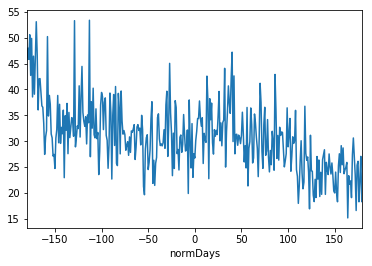

In [20]:
control_review_actor_curve.plot()

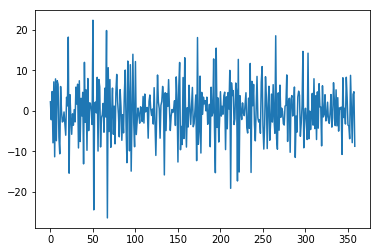

In [21]:
plt.plot(np.diff(control_review_actor_curve))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  


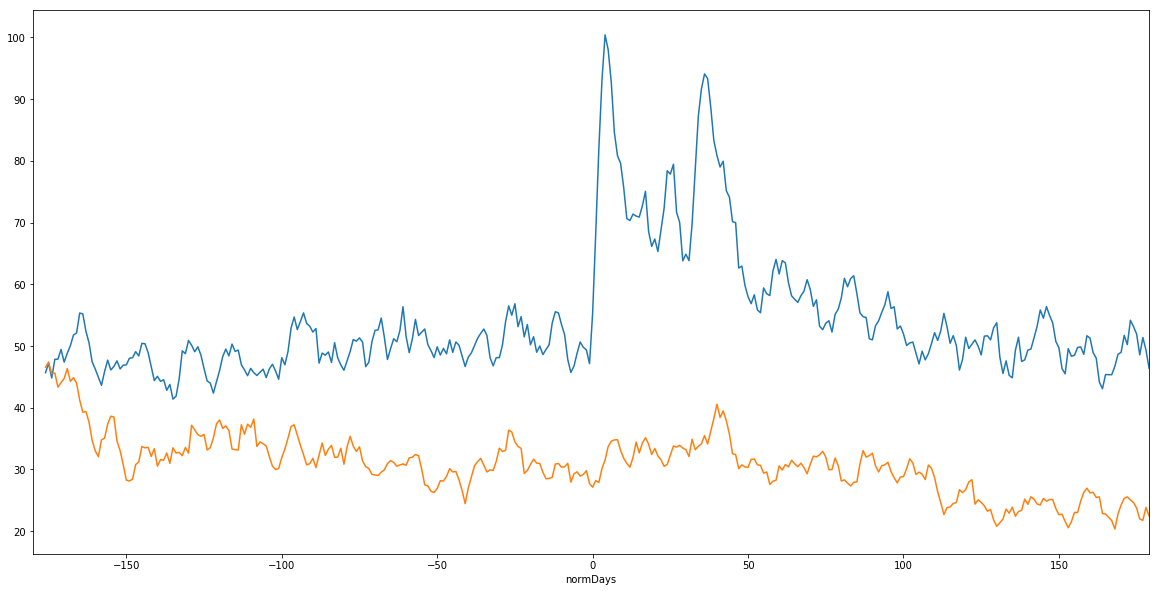

In [22]:
pd.rolling_mean(subject_review_actor_curve,5).plot(figsize=(20,10))
pd.rolling_mean(control_review_actor_curve,5).plot(figsize=(20,10))

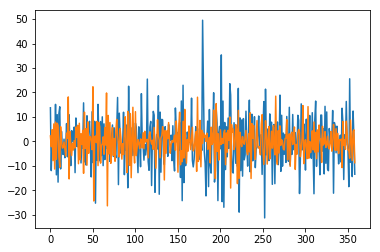

In [23]:
plt.plot(np.diff(subject_review_actor_curve))
plt.plot(np.diff(control_review_actor_curve))

### P value

In [24]:
_, p_actor = stats.ttest_ind(subject_review_actor,control_review_actor,axis=1,equal_var=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


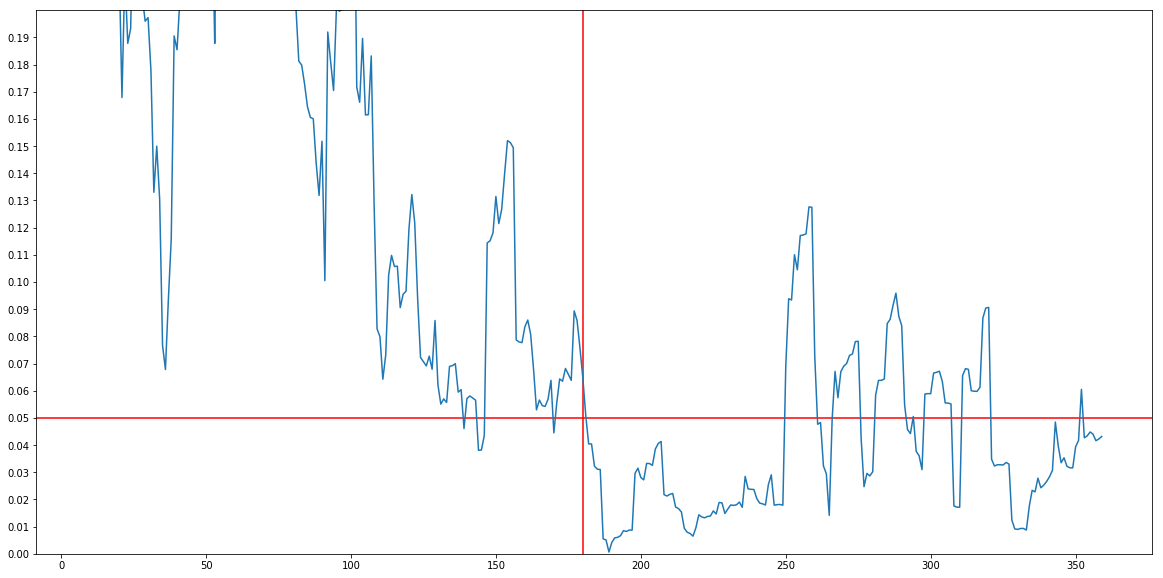

In [25]:
plt.figure(figsize=(20,10))
plt.axhline(y=0.05,color='red')
plt.axvline(x=180,color='red')
plt.yticks(np.arange(0, 0.2, 0.010))
plt.plot(pd.rolling_mean(p_actor,10))
#plt.plot(p)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.2))
plt.show()

# Musician

In [26]:
df_music_subject = pd.read_csv('reviews_subjects_500_musician.csv')
df_music_subject.head()

FileNotFoundError: File b'reviews_subjects_500_musician.csv' does not exist

In [ ]:
dead_musicians = extractActors(df_music_subject, yearThreshold, month_before)
subject_review_musician = AggAllNormDays(df_music_subject, scalingReviewMusic, dead_musicians, month_before, month_after)
subject_review_musician_curve = subject_review_musician.sum(axis=1)
subject_review_musician_curve.plot()

In [ ]:
plt.plot(np.diff(subject_review_musician_curve))

In [ ]:
df_musician_control = pd.read_csv('reviews_controls_500_musician.csv')
df_musician_control.head()

In [ ]:
matching_subject_musician_control = pd.read_csv('matchings_500_feature=yearbefore_musician.csv')
matching_subject_musician_control = matching_subject_musician_control[['ctrl_name','death date']].set_index('ctrl_name')

In [ ]:
df_musician_control['death date'] = df_musician_control.apply(lambda row: computeDeathDateCtrl(matching_subject_musician_control, row),axis=1)
df_musician_control.head()

In [ ]:
alive_musician_control = extractActors(df_musician_control, yearThreshold, month_before)
control_review_musician = AggAllNormDays(df_musician_control, scalingReviewMusic, alive_musician_control, month_before, month_after)
control_review_musician_curve = control_review_musician.sum(axis=1)

In [ ]:
control_review_musician_curve.plot()

In [ ]:
plt.plot(np.diff(control_review_musician_curve))

In [ ]:
pd.rolling_mean(subject_review_musician_curve,5).plot(figsize=(20,10))
pd.rolling_mean(control_review_musician_curve,5).plot(figsize=(20,10))

In [ ]:
plt.plot(np.diff(subject_review_musician_curve))
plt.plot(np.diff(control_review_musician_curve))

### P value

In [ ]:
_, p_musician = stats.ttest_ind(subject_review_musician,control_review_musician,axis=1,equal_var=False)

In [ ]:
plt.figure(figsize=(20,10))
plt.axhline(y=0.05, color='red')
plt.axvline(x=180, color='red')
plt.yticks(np.arange(0, 0.2, 0.010))
plt.plot(pd.rolling_mean(p_musician, 10))
#plt.plot(p)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.2))
plt.show()

# Particular case (famous death)

### Paul Walker

In [ ]:
paul_walker_review = AggAllNormDays(df_actor_subject,scalingReviewFilm,[("paul walker","2013-11-30")],10,10)

In [ ]:
paul_walker_review.rolling(window=10,center=False).mean().plot()

### Heath Ledger

In [ ]:
heath_ledger_review = AggAllNormDays(df_actor_subject,scalingReviewFilm,[("heath ledger","2008-01-22")],10,10)

In [ ]:
heath_ledger_review.rolling(window=10,center=False).mean().plot()

### Amy Whinehouse

In [ ]:
amy_whinehouse_review = AggAllNormDays(df_music_subject,scalingReviewMusic,[("amy whinehouse","2011-07-23")],10,10)

In [ ]:
amy_whinehouse_review.rolling(window=10,center=False).mean().plot()

### Whitney Houston

In [ ]:
whitney_houston_review = AggAllNormDays(df_music_subject,scalingReviewMusic,[("whitney houston","2012-02-11")],10,10)

In [ ]:
whitney_houston_review.rolling(window=10,center=False).mean().plot()